# Generating trading signals with LightGBM and CatBoost

## Imports & Settings

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
import talib
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostClassifier

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, pearsonr

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [26]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [15]:
YEAR = 252
idx = pd.IndexSlice

## Get Data

In [5]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2016'], :])
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1994931 entries, ('A', Timestamp('2010-01-04 00:00:00')) to ('ZION', Timestamp('2017-12-29 00:00:00'))
Data columns (total 33 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol_rank  1994931 non-null  float64
 1   rsi              1981001 non-null  float64
 2   bb_high          1976026 non-null  float64
 3   bb_low           1976022 non-null  float64
 4   NATR             1981001 non-null  float64
 5   ATR              1981001 non-null  float64
 6   PPO              1970056 non-null  float64
 7   MACD             1962096 non-null  float64
 8   sector           1994931 non-null  int64  
 9   r01              1993936 non-null  float64
 10  r05              1989956 non-null  float64
 11  r10              1984981 non-null  float64
 12  r21              1974036 non-null  float64
 13  r42              1953141 non-null  float64
 14  r63              1932246 non-null  float6

In [43]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()

## Model Selection: Lookback, lookahead and roll-forward periods

In [40]:
tickers = data.index.get_level_values('symbol').unique()

In [41]:
lookaheads = [1, 5, 21]

In [47]:
categoricals = ['year', 'month', 'sector', 'weekday']

In [25]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63, 21]

In [50]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

## Baseline: Linear Regression

In [42]:
lr = LinearRegression()

In [51]:
lr_metrics = []
for lookahead, train_length, test_length in test_params:
    print(lookahead, train_length, test_length)
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

### Information Coefficient distribution by Lookahead

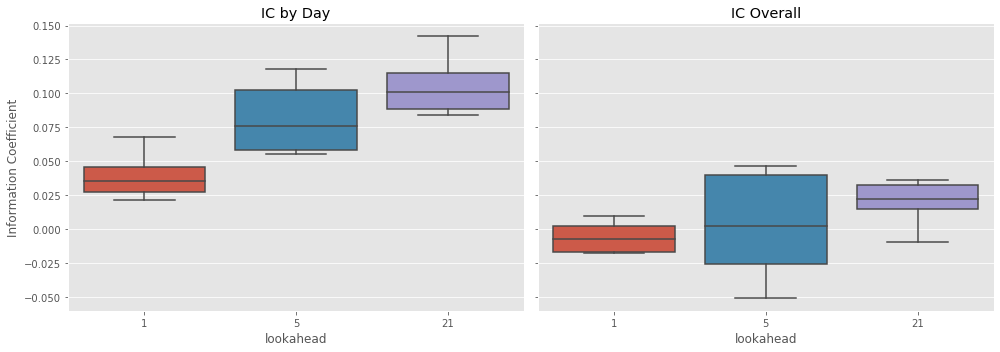

In [52]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()
# fig.savefig('figures/lr_ic', dpi=300);

### Best Train/Test Period Lengths

In [53]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
1,1,1260,63,0.021136,0.009827
5,1,126,63,0.029008,0.002819
3,1,252,63,0.026511,-0.000002
9,5,252,63,0.057864,0.046339
7,5,1260,63,0.060122,0.044523
11,5,126,63,0.055588,0.026274
16,21,126,21,0.083812,0.035986
12,21,1260,21,0.141929,0.034274
13,21,1260,63,0.116712,0.028276


In [100]:
lr_metrics.to_csv('lr_metrics.csv', index=False)

## LightGBM Model Tuning

### Hyperparameter Options

In [ ]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

In [ ]:
learning_rate_ops = [.01, .1, .3]
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
feature_fraction_opts = [.3, .6, .95]
min_data_in_leaf_opts = [250, 500, 1000]

In [ ]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [ ]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)

### Train/Test Period Lengths

In [ ]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

In [101]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [102]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


### Categorical Variables

In [ ]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [16]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

In [ ]:
store = Path('tuning_lgb.h5')

In [ ]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()

In [ ]:
label_dict = dict(zip(horizons, labels))

In [ ]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [ ]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [ ]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            lgb_train = lgb_data.subset(train_idx.tolist()).construct()
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        metrics.to_hdf(store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(store, 'fi/' + key)
        cv_preds.to_hdf(store, 'predictions/' + key)

## CatBoost Model Tuning

### Hyperparameter Options

In [3]:
param_names = ['max_depth', 'min_child_samples']

max_depth_opts = [3, 5, 7, 9]
min_child_samples_opts = [20, 250, 500]

In [4]:
cv_params = list(product(max_depth_opts,
                         min_child_samples_opts))
n_params = len(cv_params)

### Train/Test Period Lengths

In [11]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

In [12]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]

In [13]:
test_params = list(product(lookaheads,
                           train_lengths,
                           test_lengths))

### Custom Loss Function

In [ ]:
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

### Run Cross-Validation

In [5]:
num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_boost_round = num_iterations[-1]

In [ ]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [ ]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 1),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
    catboost_data = Pool(label=outcome_data[label],
                         data=outcome_data.drop(label, axis=1),
                         cat_features=cat_cols_idx)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{train_length}/{test_length}'
    T = 0
    for p, param_vals in enumerate(cv_params_):
        params = dict(zip(param_names, param_vals))
        params['task_type'] = 'GPU'

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            train_set = catboost_data.slice(train_idx.tolist())

            model = CatBoostRegressor(**params)
            model.fit(X=train_set,
                      verbose_eval=False)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_names_]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, ntree_end=n) for n in num_iterations}
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | {params["min_child_samples"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)
        metrics.to_hdf(store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(store, 'daily_ic/' + key)
        cv_preds.to_hdf(store, 'predictions/' + key)

## Generate predictions

### Model Configuration

In [16]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

categoricals = ['year', 'month', 'sector', 'weekday']

In [17]:
lookahead = 1
store = Path('predictions.h5')

### Get Data

In [18]:
data = pd.read_hdf('data.h5', 'model_data').sort_index()
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()
label = f'r{lookahead:02}_fwd'
data = data.loc[idx[:, '2010':], features + [label]].dropna()
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [19]:
lgb_data = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

### Generate predictions

In [ ]:
for position in range(10):
    params = get_params(daily_ic_avg,
                    t=lookahead,
                    best=position)
    
    params = params.to_dict()
    
    for p in ['min_data_in_leaf', 'num_leaves']:
        params[p] = int(params[p])
    train_length = int(params.pop('train_length'))
    test_length = int(params.pop('test_length'))
    num_boost_round = int(params.pop('boost_rounds'))
    params.update(base_params)

    print(f'\nPosition: {position:02}')

    n_splits = int(1 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    predictions = []
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
        print(i, end=' ', flush=True)
        lgb_train = lgb_data.subset(train_idx.tolist()).construct()

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_round,
                          verbose_eval=False)

        test_set = data.iloc[test_idx, :]
        y_test = test_set.loc[:, label].to_frame('y_test')
        y_pred = model.predict(test_set.loc[:, model.feature_name()])
        predictions.append(y_test.assign(prediction=y_pred))

    if position == 0:
        test_predictions = (pd.concat(predictions)
                            .rename(columns={'prediction': position}))
    else:
        test_predictions[position] = pd.concat(predictions).prediction

by_day = test_predictions.groupby(level='date')
for position in range(10):
    if position == 0:
        ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
    else:
        ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
print(ic_by_day.describe())
ic_by_day.to_csv(f'ic_by_day_{lookahead:02}.csv')

key = f'{lookahead:02}'
test_predictions.to_hdf(store, 'test/' + key)

### AlphaLens Analysis

#### Prepare Factor Data

In [7]:
t = 1
idx = pd.IndexSlice
factor = (pd.read_hdf('predictions.h5', f'test/{t:02}')
          .drop('y_test', axis=1)
          .iloc[:, :5]
          .mean(1)
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [13]:
dates = factor.index.get_level_values('date')
dates.min(), dates.max()

(Timestamp('2015-12-29 00:00:00+0000', tz='UTC'),
 Timestamp('2017-12-28 00:00:00+0000', tz='UTC'))

In [8]:
factor.head()

date                       symbol
2015-12-29 00:00:00+00:00  A        -0.003283
2015-12-30 00:00:00+00:00  A        -0.002505
2015-12-31 00:00:00+00:00  A        -0.000510
2016-01-04 00:00:00+00:00  A        -0.000549
2016-01-05 00:00:00+00:00  A         0.000030
dtype: float64

#### Select next available trade prices

Using next available prices.

In [10]:
tickers = factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Columns: 995 entries, A to ZION
dtypes: float64(995)
memory usage: 5.7 MB


#### Get AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

#### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)